# **Assignment 0 Deep Vision Language Models**

# **Name: Mubeen Ahmed**

# **Roll no. 25280101**

# **Task 1: Inner Working of RestNet-152**


In [1]:
# import libararies
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
# device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# **Part 1: Baseline Setup**


In [2]:
# a).  load pre-trainned model - ResNet152
model  = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)

print(f"Loaded ResNet-152 with {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")
print(f"Original final layer: {model.fc}")

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/mubeen/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [04:44<00:00, 850kB/s]  


Loaded ResNet-152 with 60.2M parameters
Original final layer: Linear(in_features=2048, out_features=1000, bias=True)


In [5]:
# b) replace the final classification layer for CIFAR-10

num_classes = 10 # CIFAR-10 has 10 classes
in_features = model.fc.in_features # input features for final layer
model.fc = nn.Linear(in_features, num_classes) # replace final layer
model = model.to(device)

print(f"Replaced final layer: {model.fc}")


Replaced final layer: Linear(in_features=2048, out_features=10, bias=True)


In [6]:
# c) train only classification and freeze backbone layers
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Trainable parameters: 20,490 (0.04%)
Frozen parameters: 58,143,808


In [7]:

# d). record training and validation performance 

transform = transforms.Compose([        
    transforms.Resize((224, 224)), # resize to 224x224 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# training setup 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # only optimize the final layer

def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# evaluate model
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# record  performance 
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
print(f"\nfinal Test Accuracy: {history['val_acc'][-1]:.2f}%")    

100%|██████████| 170M/170M [07:59<00:00, 356kB/s]    


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Evaluating: 100%|██████████| 313/313 [00:43<00:00,  7.18it/s]


Epoch 1/5: Train Loss: 0.6665, Train Acc: 0.7898 | Val Loss: 0.5054, Val Acc: 0.8366


Evaluating: 100%|██████████| 313/313 [00:42<00:00,  7.31it/s]


Epoch 2/5: Train Loss: 0.4968, Train Acc: 0.8334 | Val Loss: 0.4661, Val Acc: 0.8465


Evaluating: 100%|██████████| 313/313 [00:45<00:00,  6.94it/s]


Epoch 3/5: Train Loss: 0.4653, Train Acc: 0.8414 | Val Loss: 0.4644, Val Acc: 0.8440


Evaluating: 100%|██████████| 313/313 [00:43<00:00,  7.17it/s]


Epoch 4/5: Train Loss: 0.4445, Train Acc: 0.8485 | Val Loss: 0.4824, Val Acc: 0.8411


Evaluating: 100%|██████████| 313/313 [00:47<00:00,  6.59it/s]

Epoch 5/5: Train Loss: 0.4315, Train Acc: 0.8514 | Val Loss: 0.4586, Val Acc: 0.8423

final Test Accuracy: 0.84%


# **Part 2: Residual Connections in Practice**

In [8]:
import copy
# a).  create a bottleneck layer without skip connection
class BottleneckLayerNoSkip(nn.Module):
    def __init__(self, orignal_block):
        super().__init__()
        self.conv1 = orignal_block.conv1
        self.bn1 = orignal_block.bn1
        self.relu = orignal_block.relu
        self.conv2 = orignal_block.conv2
        self.bn2 = orignal_block.bn2
        self.conv3 = orignal_block.conv3
        self.bn3 = orignal_block.bn3
        
       
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        return out 
    
# fucntion to disable the skip connection in specific layers 
def disable_skip_connections(model, layer_names = ['layer3', 'layer4']):
    for layer_name in layer_names:
        layer = getattr(model, layer_name)
        for i in range(len(layer)):
            layer[i] = BottleneckLayerNoSkip(layer[i])
                
    print(f"Skip connections disabled in layers: {layer_names}")
        
    return model

model_without_skip = copy.deepcopy(model)
# disable skip connections in layer3 and layer4
model_without_skip = disable_skip_connections(model_without_skip, ['layer3', 'layer4'])
model_without_skip = model_without_skip.to(device)


for param in model_without_skip.parameters():
    param.requires_grad = False
for param in model_without_skip.fc.parameters():
    param.requires_grad = True



Skip connections disabled in layers: ['layer3', 'layer4']


Epoch 1/5


Evaluating: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


Train Loss: 2.308 | Train Acc: 0.10
Val Loss: 1512.5998 | Val Acc: 0.10
Epoch 2/5


Evaluating: 100%|██████████| 313/313 [00:40<00:00,  7.67it/s]


Train Loss: 2.305 | Train Acc: 0.10
Val Loss: 25528.7612 | Val Acc: 0.10
Epoch 3/5


Evaluating: 100%|██████████| 313/313 [00:38<00:00,  8.14it/s]


Train Loss: 2.304 | Train Acc: 0.10
Val Loss: 4136.3187 | Val Acc: 0.10
Epoch 4/5


Evaluating: 100%|██████████| 313/313 [00:38<00:00,  8.16it/s]


Train Loss: 2.305 | Train Acc: 0.10
Val Loss: 2412.9108 | Val Acc: 0.10
Epoch 5/5


Evaluating: 100%|██████████| 313/313 [00:41<00:00,  7.47it/s]


Train Loss: 2.304 | Train Acc: 0.10
Val Loss: 4348.8873 | Val Acc: 0.10

COMPARISON RESULTS:
WITH skip connections    - Final Val Acc: 0.84%
WITHOUT skip connections - Final Val Acc: 0.10%
Performance Drop: 0.74%
Comparison results saved as 'skip_comparison_results.png'


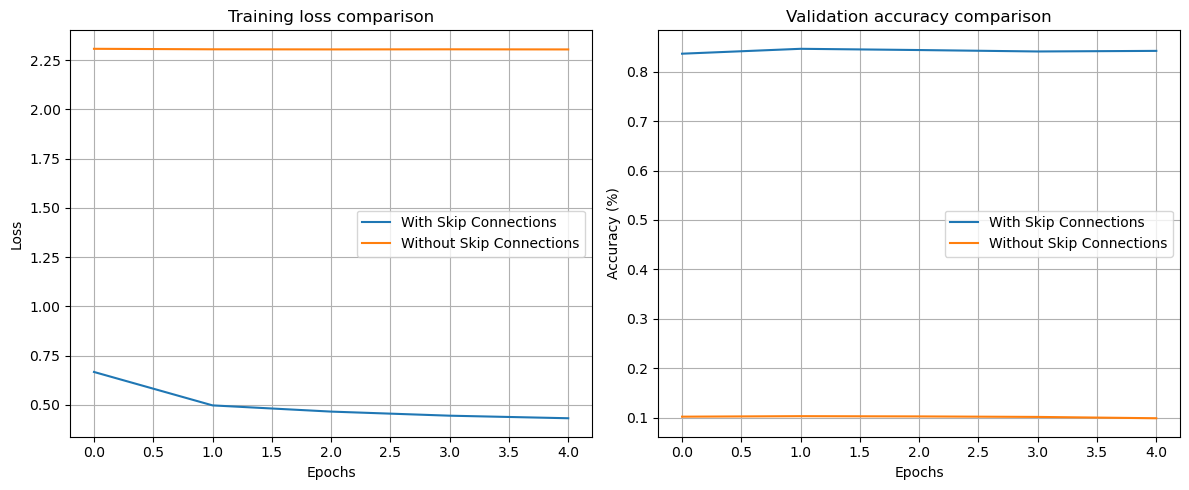

In [9]:
# b) comapre training dynamics and validation accuracy

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_skip.fc.parameters(), lr=0.001) # only optimize the final layer

num_epochs = 5
history_no_skip = {'train_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # train and evaluate
    train_loss, train_acc = train_epoch(model_without_skip, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model_without_skip, test_loader, criterion)

    history_no_skip['train_loss'].append(train_loss)
    history_no_skip['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}")
    
# compare the basseline 
print("\n" + "="*60)
print("COMPARISON RESULTS:")
print("="*60)
print(f"WITH skip connections    - Final Val Acc: {history['val_acc'][-1]:.2f}%")
print(f"WITHOUT skip connections - Final Val Acc: {history_no_skip['val_acc'][-1]:.2f}%")
print(f"Performance Drop: {history['val_acc'][-1] - history_no_skip['val_acc'][-1]:.2f}%")
print("="*60)


# plot comparison results
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # loss plot
plt.plot(history['train_loss'], label='With Skip Connections')
plt.plot(history_no_skip['train_loss'], label='Without Skip Connections')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss comparison')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='With Skip Connections')
plt.plot(history_no_skip['val_acc'], label='Without Skip Connections')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation accuracy comparison')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.savefig('skip_comparison_results.png')
print("Comparison results saved as 'skip_comparison_results.png'")

plt.show()

# **3. Features Hierarchies and Representation**

In [10]:
# a). collect features from layer early middle and late layers 

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

def extract_features(model, dataloader, num_samples=1000):
    model.eval()
    
    
    features = {'early': [], 'middle': [], 'late': [], 'labels': []}
    
    activations = {} #storage for activations
    
    def get_activation(name): #hook function to caputure outputs
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # register hook
    hook1 = model.layer1.register_forward_hook(get_activation('early'))
    hook2 = model.layer2.register_forward_hook(get_activation('middle'))
    hook3 = model.layer4.register_forward_hook(get_activation('late'))
    
    # extract features
    count = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            if count >= num_samples:
                break
            
            
            inputs = inputs.to(device)
            _ = model(inputs) # forward pass triggering hooks
            
            # process activations
            for layer_name in ['early', 'middle', 'late']:
                feat = activations[layer_name]
                
                # global average pooling
                feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1)).squeeze() # after pooling remove spatial dimensions
                features[layer_name].append(feat.cpu().numpy())
            
            
            features ['labels'].append(labels.cpu().numpy())
            count += inputs.size(0)
    
    # remove hook
    hook1.remove()
    hook2.remove()
    hook3.remove()
    
    # concatenate features
    for key in features:
        features[key] = np.concatenate(features[key], axis=0)[:num_samples]
    
    print(f"Extracted features for {features['labels'].shape[0]} samples")
    print(f"Early layer features shape: {features['early'].shape}")
    print(f"Middle layer features shape: {features['middle'].shape}")
    print(f"Late layer features shape: {features['late'].shape}")
    
    return features

features =  extract_features(model, test_loader, num_samples=1000) #run extraction


Extracted features for 1000 samples
Early layer features shape: (1000, 256)
Middle layer features shape: (1000, 512)
Late layer features shape: (1000, 2048)


reducingearly features using TSNE...
reducingmiddle features using TSNE...
reducinglate features using TSNE...
Saved: features_tsne.png...


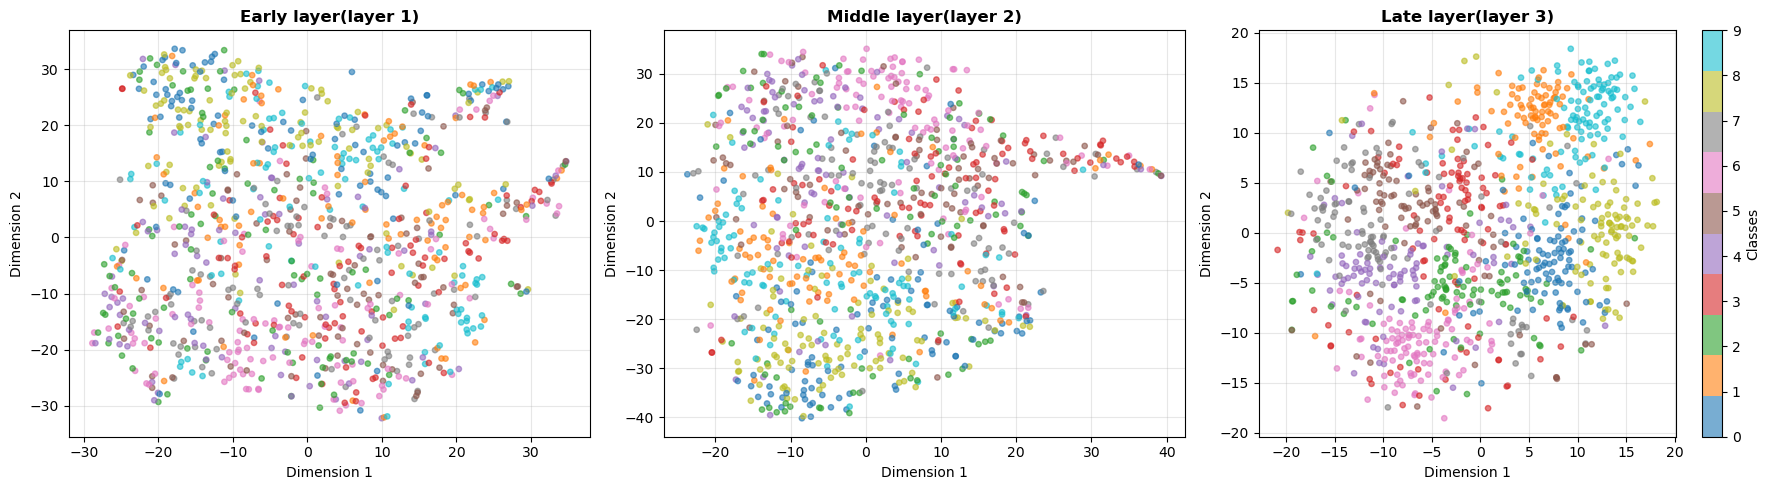

In [12]:
# b). visualize features using t-SNE

def visualize_features(features, method='tsne'):
    layer_names = ['early', 'middle', 'late']
    layer_titles = [
        'Early layer(layer 1)', 
        'Middle layer(layer 2)', 
        'Late layer(layer 3)'
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    
    for idx, (layer_name, title) in enumerate(zip(layer_names, layer_titles)):
        
        print(f"reducing{layer_name} features using {method.upper()}...")
        
        feat = features[layer_name]
        labels = features['labels']
        
        # dimensionality reduction
        if method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        elif method == 'umap':
            reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
        else:
            raise ValueError("Method must be 'tsne' or 'umap'")
        
   
        feat_2d = reducer.fit_transform(feat)
        
        # plot
        scatter =  axes[idx].scatter(
        feat_2d[:, 0], feat_2d[:, 1],
        c=labels, cmap='tab10', alpha=0.6, s=15
        )
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Dimension 1')
        axes[idx].set_ylabel('Dimension 2')
        axes[idx].grid(True, alpha=0.3)
    
        if idx == 2:
            plt.colorbar(scatter, ax=axes[idx], ticks=range(10), label='Classes')        
    
    plt.tight_layout()
    file_name = f"features_{method.lower()}.png"
    print(f"Saved: {file_name}...")
    plt.show()
visualize_features(features, method='tsne')   
    

# **4. Transfer Learning and Generalization**


In [13]:
# a) fine tune model on dataset different from imagenet 
# the dataset already loaded above is cifar10
# so we can directly fine tune the model on cifar10

print("Using CIFAR-10 dataset (different from ImageNet)")
print(f"Training samples :{len(train_dataset)}")
print(f"Test samples :{len(test_dataset)}")

Using CIFAR-10 dataset (different from ImageNet)
Training samples :50000
Test samples :10000


In [ ]:
# b) comapre performance between using pretrained weights and random initialization

import torchvision.models as models 
from torchvision.models import ResNet152_Weights

# imageNet pre-trained weights 
def setup_pretrained_model():
    model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
    model.fc = nn.Linear(model.fc.in_features, 10)
    
    # freeze backbone layers
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
        
        
    return model.to(device)


# random initialized model
def setup_random_model():
    model = models.resnet152(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    
    # all layers trainable
    for param in model.parameters():
        param.requires_grad = True
    
    return model.to(device)

# train with pre-trained weights
print("\n" + "="*60)
print("Training with ImageNet PRETRAINED weights (frozen backbone)")
print("="*60)

model_pretrained = setup_pretrained_model()
optimizer_pretrained = optim.Adam(model_pretrained.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history_pretrained = {'train_loss': [], 'val_acc': []}

for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(model_pretrained, train_loader, criterion, optimizer_pretrained)
    val_loss, val_acc = evaluate(model_pretrained, test_loader, criterion)
    
    history_pretrained['train_loss'].append(train_acc)
    history_pretrained['val_acc'].append(val_acc)
    
    
    print(f"Train acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    



Training with ImageNet PRETRAINED weights (frozen backbone)
Epoch 1/5


Evaluating: 100%|██████████| 313/313 [00:44<00:00,  7.00it/s]


Train acc: 0.78% | Val Acc: 0.84%
Epoch 2/5


Evaluating: 100%|██████████| 313/313 [00:45<00:00,  6.83it/s]


Train acc: 0.83% | Val Acc: 0.84%
Epoch 3/5


Evaluating: 100%|██████████| 313/313 [00:45<00:00,  6.88it/s]


Train acc: 0.84% | Val Acc: 0.85%
Epoch 4/5


Evaluating: 100%|██████████| 313/313 [00:44<00:00,  6.99it/s]


Train acc: 0.85% | Val Acc: 0.85%
Epoch 5/5


Evaluating: 100%|██████████| 313/313 [00:45<00:00,  6.87it/s]


Train acc: 0.86% | Val Acc: 0.85%

Training with random initialization
Epoch 1/5


Training:   0%|          | 1/1563 [00:00<23:59,  1.09it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 97.38 MiB is free. Including non-PyTorch memory, this process has 6.98 GiB memory in use. Of the allocated memory 6.54 GiB is allocated by PyTorch, and 318.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [21]:
import torch
import gc

# 1. Delete the previous model to free the memory reference
# (Replace 'model' or 'model_pretrained' with whatever variable name you used previously)
if 'model' in globals():
    del model
if 'optimizer' in globals():
    del optimizer
if 'model_pretrained' in globals():
    del model_pretrained

# 2. Force Python's garbage collector to release the memory
gc.collect()

# 3. Clear PyTorch's internal CUDA cache
torch.cuda.empty_cache()

print("GPU Memory Cleared!")
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU Memory Cleared!
Allocated: 0.89 GB
Cached: 1.29 GB


In [22]:
# train with random initialization
print("\n" + "="*60)
print("Training with random initialization")
print("="*60)

model_random = setup_random_model()
optimizer_random = optim.Adam(model_random.parameters(), lr=0.0001) 

history_random = {'train_loss': [], 'val_acc': []}

for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(model_random, train_loader, criterion, optimizer_random)
    val_loss, val_acc = evaluate(model_random, test_loader, criterion)
    
    history_random['train_loss'].append(train_acc)
    history_random['val_acc'].append(val_acc)
    
    
    print(f"Train acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    
# compare results
print("\n" + "="*60)
print("COMPARISON RESULTS: Pretrained vs Random Initialization")
print("="*60)
print(f"Pretrained (frozen) - Final Val Acc: {history_pretrained['val_acc'][-1]:.2f}%")
print(f"Random Init (full)  - Final Val Acc: {history_random['val_acc'][-1]:.2f}%")
print(f"Difference: {history_pretrained['val_acc'][-1] - history_random['val_acc'][-1]:.2f}%")
print("="*60)


Training with random initialization
Epoch 1/5


Evaluating: 100%|██████████| 313/313 [00:46<00:00,  6.73it/s]


Train acc: 0.34% | Val Acc: 0.42%
Epoch 2/5


Evaluating: 100%|██████████| 313/313 [00:51<00:00,  6.06it/s]


Train acc: 0.48% | Val Acc: 0.55%
Epoch 3/5


Evaluating: 100%|██████████| 313/313 [00:49<00:00,  6.28it/s]


Train acc: 0.58% | Val Acc: 0.57%
Epoch 4/5


Evaluating: 100%|██████████| 313/313 [00:50<00:00,  6.16it/s]


Train acc: 0.67% | Val Acc: 0.68%
Epoch 5/5


Evaluating: 100%|██████████| 313/313 [00:48<00:00,  6.39it/s]

Train acc: 0.74% | Val Acc: 0.74%

COMPARISON RESULTS: Pretrained vs Random Initialization
Pretrained (frozen) - Final Val Acc: 0.85%
Random Init (full)  - Final Val Acc: 0.74%
Difference: 0.11%


In [ ]:
# c) experiment with fine-tunning only the final block vs full backbone 

# pretrianed + fin-tuned only final block 
def setup_finetune_final_block():
    model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
    model.fc = nn.Linear(model.fc.in_features, 10)
    
    # freeze all layers except final block and fc
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True
        
    return model.to(device)

#pretrained + fine-tuned full backbone
def setup_finetune_full_backbone():
    model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
    model .fc = nn.Linear(model.fc.in_features, 10)
    
    # all layers trainable
    for param in model.parameters():
        param.requires_grad = True
    
    return model.to(device)

# experiment 1: fine-tune only final block
print("\n" + "="*60)
print("Fine-tuning only FINAL BLOCK (layer4) with pre-trained weights")
print("="*60)

model_last_block = setup_finetune_final_block()
optimizer_last_block = optim.Adam(
    filter(lambda p: p.requires_grad, model_last_block.parameters()), lr=0.0001
)  # lower lr for fine-tuning

history_last_block = {'train_loss': [], 'val_acc': []}

for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(model_last_block, train_loader, criterion, optimizer_last_block)
    val_loss, val_acc = evaluate(model_last_block, test_loader, criterion)
    
    history_last_block['train_loss'].append(train_acc)
    history_last_block['val_acc'].append(val_acc)
    
    
    print(f"Train acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    



Fine-tuning only FINAL BLOCK (layer4) with pre-trained weights
Epoch 1/5


Evaluating: 100%|██████████| 313/313 [00:50<00:00,  6.23it/s]


Train acc: 0.84% | Val Acc: 0.90%
Epoch 2/5


Evaluating: 100%|██████████| 313/313 [00:48<00:00,  6.41it/s]


Train acc: 0.92% | Val Acc: 0.92%
Epoch 3/5


Evaluating: 100%|██████████| 313/313 [00:48<00:00,  6.46it/s]


Train acc: 0.96% | Val Acc: 0.91%
Epoch 4/5


Evaluating: 100%|██████████| 313/313 [00:48<00:00,  6.41it/s]


Train acc: 0.97% | Val Acc: 0.91%
Epoch 5/5


Evaluating: 100%|██████████| 313/313 [00:48<00:00,  6.44it/s]


Train acc: 0.98% | Val Acc: 0.91%

Fine-tuning FULL BACKBONE with pre-trained weights
Epoch 1/5


Training:   0%|          | 0/1563 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 67.06 MiB is free. Including non-PyTorch memory, this process has 7.08 GiB memory in use. Of the allocated memory 6.70 GiB is allocated by PyTorch, and 248.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [63]:
# experiment 2: fine-tune full backbone
print("\n" + "="*60)
print("Fine-tuning FULL BACKBONE with pre-trained weights")
print("="*60)

model_full_backbone = setup_finetune_full_backbone()
optimizer_full_backbone = optim.Adam(
    filter(lambda p: p.requires_grad, model_full_backbone.parameters()), lr=0.0001
)  # lower lr for fine-tuning

history_full_backbone = {'train_loss': [], 'val_acc': []}

for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(model_full_backbone, train_loader, criterion, optimizer_full_backbone)
    val_loss, val_acc = evaluate(model_full_backbone, test_loader, criterion)
    
    history_full_backbone['train_loss'].append(train_loss)
    history_full_backbone['val_acc'].append(val_acc)
    
    
    print(f"Train acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Fine-tuning FULL BACKBONE with pre-trained weights
Epoch 1/5


Evaluating: 100%|██████████| 313/313 [00:53<00:00,  5.88it/s]


Train acc: 0.92% | Val Acc: 0.96%
Epoch 2/5


Evaluating: 100%|██████████| 313/313 [00:50<00:00,  6.21it/s]


Train acc: 0.98% | Val Acc: 0.97%
Epoch 3/5


Evaluating: 100%|██████████| 313/313 [00:52<00:00,  5.93it/s]


Train acc: 0.98% | Val Acc: 0.96%
Epoch 4/5


Evaluating: 100%|██████████| 313/313 [00:49<00:00,  6.32it/s]


Train acc: 0.99% | Val Acc: 0.96%
Epoch 5/5


Evaluating: 100%|██████████| 313/313 [00:51<00:00,  6.13it/s]

Train acc: 0.99% | Val Acc: 0.96%



Final Comparison - All Samples
1. Frozen Backbone (only fc trained) - Final Val Acc: 0.85%
2. Fine-tuned Final Block - Final Val Acc: 0.91%
3. Fine-tuned Full Backbone - Final Val Acc: 0.96%
 Random Init (full)  - Final Val Acc: 0.74%
Comparison saved as 'transfer_learning_comparison.png'


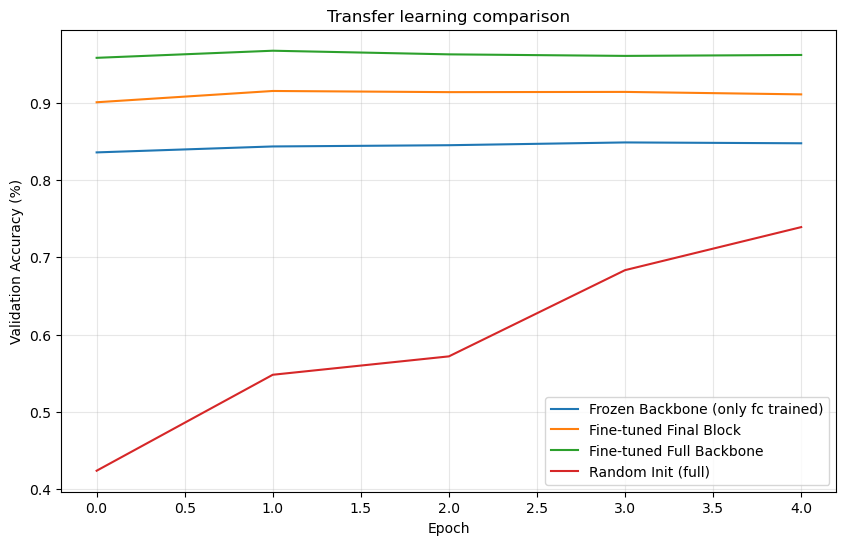

In [64]:

# compare results
print("\n" + "="*70)
print("Final Comparison - All Samples")

print(f"1. Frozen Backbone (only fc trained) - Final Val Acc: {history_pretrained['val_acc'][-1]:.2f}%")
print(f"2. Fine-tuned Final Block - Final Val Acc: {history_last_block['val_acc'][-1]:.2f}%")
print(f"3. Fine-tuned Full Backbone - Final Val Acc: {history_full_backbone['val_acc'][-1]:.2f}%")
print(f" Random Init (full)  - Final Val Acc: {history_random['val_acc'][-1]:.2f}%")


# visualization

plt.figure(figsize=(10, 6))
plt.plot(history_pretrained['val_acc'], label='Frozen Backbone (only fc trained)')
plt.plot(history_last_block['val_acc'], label='Fine-tuned Final Block')
plt.plot(history_full_backbone['val_acc'], label='Fine-tuned Full Backbone')
plt.plot(history_random['val_acc'], label='Random Init (full)')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Transfer learning comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('transfer_learning_comparison.png', dpi=300)
print("Comparison saved as 'transfer_learning_comparison.png'")